# Load preprocessed XLK ETF stock data for one year and make short term predictions.

Data: We have stock data for every minute during trading hours (09:30 to 16:00 EST). That is equivalent to 390 samples per day.
We will use one month worth of stock data (~ 22 * 390 = 8580 samples) to train multi-step RNN network. We will use 5 days worth of data as #steps in the RNN network (~5 * 390 = 1950 samples) and compare against the model that takes 2 days worth of data as #steps. In each case, we predict the stock prices with in the training period and outside of it for near term prediction.


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

c:\users\mpatnam\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import pandas as pd
import glob

path ='C:/cygwin64/home/mpatnam/CSCIE63/CSCI E-89 Deep Learning/Project/etfs'
#allFiles = glob.glob(path + "/allstocks_20140[12]*/table_xlk.csv")
allFiles = glob.glob(path + "/allstocks_2014*/table_xlk.csv")   # Load 2014 year data
allFiles += glob.glob(path + "/allstocks_201501*/table_xlk.csv")
stockdata = pd.concat([pd.read_csv(f, header=None , names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume', 
                                                  'SplitFactor', 'Earnings', 'Dividends']) for f in allFiles], axis=0)
train_lastdate='2014-02-01 00:00:00'   # 22 days of trading data
test_startdate='2014-01-02 00:00:00'   # test start-date
test_lastdate='2014-02-03 23:59:00'    # test end-date

print('Total rows x columns:', stockdata.shape)
stockdata.head()

Total rows x columns: (108033, 10)


,Date,Time,Open,High,Low,Close,Volume,SplitFactor,Earnings,Dividends
0,20140102,800,33.4127,33.4127,33.4127,33.4127,234.3850,1,0,0.0
1,20140102,841,33.3940,33.3940,33.3940,33.3940,57.7937,1,0,0.0
2,20140102,913,33.3846,33.3846,33.3846,33.3846,149.8350,1,0,0.0
3,20140102,930,33.2818,33.2818,33.1884,33.2164,182545.0000,1,0,0.0
4,20140102,931,33.2164,33.2164,33.1978,33.2024,23803.5000,1,0,0.0


In [5]:
#
# Understand dataset first
#

# print header columns
print('--------------------------------------------------------------')
print('Column datatypes:\n', stockdata.dtypes)
print('--------------------------------------------------------------')
print('2nd row:\n', stockdata.iloc[2])   # display 2nd row
print('--------------------------------------------------------------')
print('2nd row (from last):\n', stockdata.iloc[-2])   # display 2nd row
print('--------------------------------------------------------------')
print('StockData price column: ', stockdata.columns[5])
print('--------------------------------------------------------------')
print('Sample stock prices')
print(stockdata['Close'].head())  # this is the column of interest with temperature data

--------------------------------------------------------------
Column datatypes:
 Date             int64
Time             int64
Open           float64
High           float64
Low            float64
Close          float64
Volume         float64
SplitFactor      int64
Earnings         int64
Dividends      float64
dtype: object
--------------------------------------------------------------
2nd row:
 Date           2.014010e+07
Time           9.130000e+02
Open           3.338460e+01
High           3.338460e+01
Low            3.338460e+01
Close          3.338460e+01
Volume         1.498350e+02
SplitFactor    1.000000e+00
Earnings       0.000000e+00
Dividends      0.000000e+00
Name: 2, dtype: float64
--------------------------------------------------------------
2nd row (from last):
 Date           2.015013e+07
Time           1.634000e+03
Open           3.798860e+01
High           3.798860e+01
Low            3.798860e+01
Close          3.798860e+01
Volume         4.201260e+03
SplitFactor    1

In [6]:
#
# Data wrangling: 
# 1. Note that this is one-min stock data during trading hours (09:30 to 04:00 EST) only. Plotting such data will show 
# discontinuity in the plot for the non-trading hours. We would rather want to show stock prices as one contiguous plot
# to identify pattern. For this reason create a string representation of Date/Time just for plotting purpose.
# 2. Convert Date and Time columns into pandas DateTime type
# 3. create index on date column for faster lookups
#

# convert text date values to concrete type
print("--------------------------------------------------------")
# convert market data volume to int 
stockdata['Volume'] = stockdata['Volume'].map(int)
# convert Date/Time columns into native datetime type
stockdata['DateTimeStr'] = stockdata['Date'].map(str)+' '+stockdata['Time'].map(str)
stockdata['DateTime'] = pd.to_datetime(stockdata['DateTimeStr'], format="%Y%m%d %H%M")

# set DateTime as table index column
stockdata=stockdata.set_index(pd.DatetimeIndex(stockdata['DateTime']))
print(stockdata.dtypes)
stockdata

--------------------------------------------------------
Date                    int64
Time                    int64
Open                  float64
High                  float64
Low                   float64
Close                 float64
Volume                  int64
SplitFactor             int64
Earnings                int64
Dividends             float64
DateTimeStr            object
DateTime       datetime64[ns]
dtype: object


,Date,Time,Open,High,Low,Close,Volume,SplitFactor,Earnings,Dividends,DateTimeStr,DateTime
DateTime,,,,,,,,,,,,
2014-01-02 08:00:00,20140102,800,33.4127,33.4127,33.4127,33.4127,234,1,0,0.0,20140102 800,2014-01-02 08:00:00
2014-01-02 08:41:00,20140102,841,33.3940,33.3940,33.3940,33.3940,57,1,0,0.0,20140102 841,2014-01-02 08:41:00
2014-01-02 09:13:00,20140102,913,33.3846,33.3846,33.3846,33.3846,149,1,0,0.0,20140102 913,2014-01-02 09:13:00
2014-01-02 09:30:00,20140102,930,33.2818,33.2818,33.1884,33.2164,182545,1,0,0.0,20140102 930,2014-01-02 09:30:00
2014-01-02 09:31:00,20140102,931,33.2164,33.2164,33.1978,33.2024,23803,1,0,0.0,20140102 931,2014-01-02 09:31:00
2014-01-02 09:32:00,20140102,932,33.2071,33.2258,33.2024,33.2071,21283,1,0,0.0,20140102 932,2014-01-02 09:32:00
2014-01-02 09:33:00,20140102,933,33.2164,33.2351,33.2071,33.2118,40543,1,0,0.0,20140102 933,2014-01-02 09:33:00
2014-01-02 09:34:00,20140102,934,33.2118,33.2118,33.1884,33.1891,21332,1,0,0.0,20140102 934,2014-01-02 09:34:00
2014-01-02 09:35:00,20140102,935,33.1978,33.2071,33.1791,33.1884,17642,1,0,0.0,20140102 935,2014-01-02 09:35:00


In [7]:
stockdata_one_day=stockdata.loc[stockdata['DateTime'] < '2014-01-03 00:00:00']
print(stockdata_one_day.shape)
stockdata_one_day.head()

(400, 12)


,Date,Time,Open,High,Low,Close,Volume,SplitFactor,Earnings,Dividends,DateTimeStr,DateTime
DateTime,,,,,,,,,,,,
2014-01-02 08:00:00,20140102,800,33.4127,33.4127,33.4127,33.4127,234,1,0,0.0,20140102 800,2014-01-02 08:00:00
2014-01-02 08:41:00,20140102,841,33.3940,33.3940,33.3940,33.3940,57,1,0,0.0,20140102 841,2014-01-02 08:41:00
2014-01-02 09:13:00,20140102,913,33.3846,33.3846,33.3846,33.3846,149,1,0,0.0,20140102 913,2014-01-02 09:13:00
2014-01-02 09:30:00,20140102,930,33.2818,33.2818,33.1884,33.2164,182545,1,0,0.0,20140102 930,2014-01-02 09:30:00
2014-01-02 09:31:00,20140102,931,33.2164,33.2164,33.1978,33.2024,23803,1,0,0.0,20140102 931,2014-01-02 09:31:00


In [8]:
stockdata_one_week=stockdata.loc[stockdata['DateTime'] < '2014-01-09 00:00:00']
print(stockdata_one_week.shape)
stockdata_one_week.head()

(1992, 12)


,Date,Time,Open,High,Low,Close,Volume,SplitFactor,Earnings,Dividends,DateTimeStr,DateTime
DateTime,,,,,,,,,,,,
2014-01-02 08:00:00,20140102,800,33.4127,33.4127,33.4127,33.4127,234,1,0,0.0,20140102 800,2014-01-02 08:00:00
2014-01-02 08:41:00,20140102,841,33.3940,33.3940,33.3940,33.3940,57,1,0,0.0,20140102 841,2014-01-02 08:41:00
2014-01-02 09:13:00,20140102,913,33.3846,33.3846,33.3846,33.3846,149,1,0,0.0,20140102 913,2014-01-02 09:13:00
2014-01-02 09:30:00,20140102,930,33.2818,33.2818,33.1884,33.2164,182545,1,0,0.0,20140102 930,2014-01-02 09:30:00
2014-01-02 09:31:00,20140102,931,33.2164,33.2164,33.1978,33.2024,23803,1,0,0.0,20140102 931,2014-01-02 09:31:00


In [9]:
# Fetch stock samples into a numpy array (for training purpose)
print('train: last:', train_lastdate)
print('test: start:', test_startdate, ' last:', test_lastdate)
prices = stockdata.loc[stockdata['DateTime'] < train_lastdate].values[:,5].astype(float) # training purpose
print()
test_lastdate='2014-02-03 23:59:00' 
tmp = stockdata.loc[stockdata['DateTime'] < test_lastdate]                  # testing purpose
prices_test = tmp.loc[tmp['DateTime'] > test_startdate]
print(len(prices_test['DateTime']))
prices_test

train: last: 2014-02-01 00:00:00
test: start: 2014-01-02 00:00:00  last: 2014-02-03 23:59:00

8864


,Date,Time,Open,High,Low,Close,Volume,SplitFactor,Earnings,Dividends,DateTimeStr,DateTime
DateTime,,,,,,,,,,,,
2014-01-02 08:00:00,20140102,800,33.4127,33.4127,33.4127,33.4127,234,1,0,0.0,20140102 800,2014-01-02 08:00:00
2014-01-02 08:41:00,20140102,841,33.3940,33.3940,33.3940,33.3940,57,1,0,0.0,20140102 841,2014-01-02 08:41:00
2014-01-02 09:13:00,20140102,913,33.3846,33.3846,33.3846,33.3846,149,1,0,0.0,20140102 913,2014-01-02 09:13:00
2014-01-02 09:30:00,20140102,930,33.2818,33.2818,33.1884,33.2164,182545,1,0,0.0,20140102 930,2014-01-02 09:30:00
2014-01-02 09:31:00,20140102,931,33.2164,33.2164,33.1978,33.2024,23803,1,0,0.0,20140102 931,2014-01-02 09:31:00
2014-01-02 09:32:00,20140102,932,33.2071,33.2258,33.2024,33.2071,21283,1,0,0.0,20140102 932,2014-01-02 09:32:00
2014-01-02 09:33:00,20140102,933,33.2164,33.2351,33.2071,33.2118,40543,1,0,0.0,20140102 933,2014-01-02 09:33:00
2014-01-02 09:34:00,20140102,934,33.2118,33.2118,33.1884,33.1891,21332,1,0,0.0,20140102 934,2014-01-02 09:34:00
2014-01-02 09:35:00,20140102,935,33.1978,33.2071,33.1791,33.1884,17642,1,0,0.0,20140102 935,2014-01-02 09:35:00


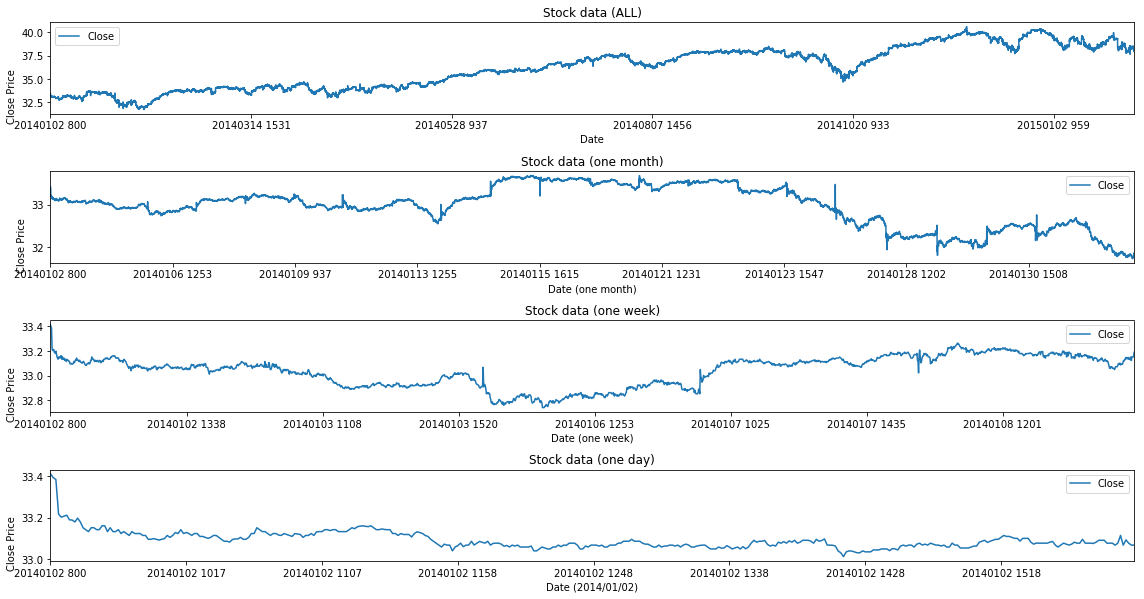

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))

#
# plot stock prices for different time periods just to understand the pattern
#
# plot the stock prices for the entire data
plt.subplot(411)
stockdata.plot(x='DateTimeStr', y='Close', ax=plt.gca())
plt.xlabel("Date")
plt.ylabel("Close Price", horizontalalignment = 'right')
plt.title("Stock data (ALL)")
plt.tight_layout()

# plot the prices for one month
plt.subplot(412)
prices_test.plot(x='DateTimeStr', y='Close', ax=plt.gca())
plt.xlabel("Date (one month)")
plt.ylabel("Close Price", horizontalalignment = 'right')
plt.title("Stock data (one month)")
plt.tight_layout()

# plot the prices for one week
plt.subplot(413)
stockdata_one_week.plot(x='DateTimeStr', y='Close', ax=plt.gca())
plt.xlabel("Date (one week)")
plt.ylabel("Close Price", horizontalalignment = 'right')
plt.title("Stock data (one week)")
plt.tight_layout()

# plot the price for one day
plt.subplot(414)
stockdata_one_day.plot(x='DateTimeStr', y='Close', ax=plt.gca())
plt.xlabel("Date (2014/01/02)")
plt.ylabel("Close Price", horizontalalignment = 'right')
plt.title("Stock data (one day)")

plt.show()

### From the plot, it is clear that stock price varies widely regardless of how long the time period. Numerous factors that includes company's performance, sector overall performance, macro-economic trends, geo-political events affect stock prices in general.

In [11]:
#
# Next batch generation - 
# data: The original array of floating point data (normalized).
# batch_size: The number of samples per batch. We use randomization to identiy the start of each seq in the input data
#             in order to generate 'batch_size' sequences.
# n_steps: The period, in timesteps, at which we sample data.
# n_lag: How many timesteps in the future should our target be.
#
def next_batch(data, batch_size, n_steps, n_lag=1, debug=0):
    t_min, t_max = 0, len(data)
    t0 = np.random.randint(t_min, t_max - n_steps - n_lag, batch_size)
    Ts = np.array([np.arange(t, t + n_steps + n_lag) for t in t0])   # batch_size x (n_steps+n_lag) matrix of indices into data vector
    ys = np.array([data[t] for t in Ts])
    
    if (debug):
        print(t0)
        print(Ts.shape)
        print(Ts)        
        print(ys.shape)
        print(ys)
    return ys[:, :-n_lag].reshape(-1, n_steps, 1), ys[:, n_lag:].reshape(-1, n_steps, 1)

In [12]:
#
# Normalize the stock prices using mean/SD - 
#
prices_normal = prices.tolist()
mean = np.mean(prices)
std = np.std(prices)
print('mean:', round(mean, 5), ', std:', round(std, 5))

prices_normal -= mean
prices_normal /= std

print('Sample first few prices (raw):', prices[:5])   # first 5 values
print('Sample last few prices (raw):', prices[-5:])   # last 5 values
#print('Sample first few prices (raw):', prices_test['Close'][:5].tolist())   # first 5 values
print('Sample first few prices (normalized):', prices_normal[:5])
print('Sample last few prices (normalized):', prices_normal[-5:])
print('Train data size: ', len(prices_normal))

mean: 33.00573 , std: 0.42755
Sample first few prices (raw): [33.4127 33.394  33.3846 33.2164 33.2024]
Sample last few prices (raw): [32.553  32.5344 32.5344 32.5344 32.5998]
Sample first few prices (normalized): [0.95186811 0.9081308  0.8861452  0.49274325 0.45999874]
Sample last few prices (normalized): [-1.05887891 -1.10238234 -1.10238234 -1.10238234 -0.94941868]
Train data size:  8468


In [13]:
prices_test['CloseNormal'] = (prices_test['Close'] - mean)/std
prices_test

,Date,Time,Open,High,Low,Close,Volume,SplitFactor,Earnings,Dividends,DateTimeStr,DateTime,CloseNormal
DateTime,,,,,,,,,,,,,
2014-01-02 08:00:00,20140102,800,33.4127,33.4127,33.4127,33.4127,234,1,0,0.0,20140102 800,2014-01-02 08:00:00,0.951868
2014-01-02 08:41:00,20140102,841,33.3940,33.3940,33.3940,33.3940,57,1,0,0.0,20140102 841,2014-01-02 08:41:00,0.908131
2014-01-02 09:13:00,20140102,913,33.3846,33.3846,33.3846,33.3846,149,1,0,0.0,20140102 913,2014-01-02 09:13:00,0.886145
2014-01-02 09:30:00,20140102,930,33.2818,33.2818,33.1884,33.2164,182545,1,0,0.0,20140102 930,2014-01-02 09:30:00,0.492743
2014-01-02 09:31:00,20140102,931,33.2164,33.2164,33.1978,33.2024,23803,1,0,0.0,20140102 931,2014-01-02 09:31:00,0.459999
2014-01-02 09:32:00,20140102,932,33.2071,33.2258,33.2024,33.2071,21283,1,0,0.0,20140102 932,2014-01-02 09:32:00,0.470992
2014-01-02 09:33:00,20140102,933,33.2164,33.2351,33.2071,33.2118,40543,1,0,0.0,20140102 933,2014-01-02 09:33:00,0.481984
2014-01-02 09:34:00,20140102,934,33.2118,33.2118,33.1884,33.1891,21332,1,0,0.0,20140102 934,2014-01-02 09:34:00,0.428891
2014-01-02 09:35:00,20140102,935,33.1978,33.2071,33.1791,33.1884,17642,1,0,0.0,20140102 935,2014-01-02 09:35:00,0.427254


X_batch shape: (50, 1950, 1)
y_batch shape: (50, 1950, 1)
------------------------------


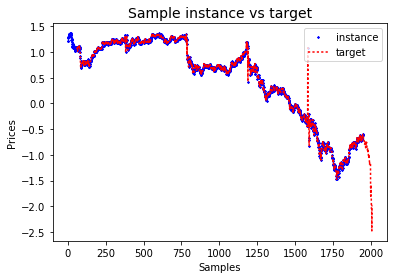

In [14]:
#
# Set the data batch generation parameters
# Generate a sample instance and target for visualization purpose
#
import matplotlib.pyplot as plt

n_days = 5                        # window of 5 trading days
n_samples_hour = 60               # number of samples per hour (input: one-min samples)
n_samples_day = 6.5 * n_samples_hour # 09:30 to 16:00 EST trading hour window (6.5 hours)
n_steps = int(n_days * n_samples_day)
n_lag = 60                        # n_steps to predict into future (60 samples = 1 hour)
batch_size = 50

X_batch, y_batch=next_batch(prices_normal, batch_size, n_steps, n_lag)
print('X_batch shape:', X_batch.shape)
print('y_batch shape:', y_batch.shape)
print('------------------------------')

# Plot instance vs target values
# note that we cannot use DateTime column due to discontinuity of data (after market)
x_label=np.arange(0, n_steps+n_lag, 1).tolist()
plt.title("Sample instance vs target", fontsize=14)
#plt.figure(figsize=(10,4), dpi=80)
plt.plot(x_label[:n_steps], X_batch[0, :, 0], "b*", markersize=2, label="instance")
plt.plot(x_label[n_lag:n_steps+n_lag], y_batch[0, :, 0], "r:", markersize=2, label="target")
plt.legend(loc="upper right")
plt.xlabel("Samples")
plt.ylabel("Prices")
plt.show()

In [15]:
#
# Define RNN model with multi-steps
#
# Model parameters:
#           Learning rate = 0.001
#           Cell type = RNN with OutputProjectionWrapper
#              #Input steps = 1950 (Samples for 5 consecutive trading days - 5 * 390 =  1950)
#              #Target steps = 1950
#              #neurons/cell = 100
#           Output activation: relu function
#           Optimizer = Adam
#           Loss function = MSE (mean squared error)
#           Training #epochs = 1000
#           Batchsize = 50
#
reset_graph()

# RNN time-step model parameters
n_inputs = 1
n_neurons = 100
n_outputs = 1

# define RNN cell with output projection to get single value out of #n_neurons by having a FC layer
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

# add FC layer to convert output vector of size 100 into one output that corresponds to time_series(t)
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Instructions for updating:
Use the retry module or similar alternatives.


In [16]:
# Training parameters
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # Loss function: MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [662]:
#
# Training phase for multi time-step RNN
#
import time
n_iterations = 800

#
# We have a vector of time-series values, train to produce the desired output for 'n' steps into future.
# We intend to predict every hour for a one full day - trading window of 6.5 hours. This corresponds 
# to a lag of 60, 120, 180, 240, 300, 360 steps into future.
# y_batch[t] = X_batch[t+n_lag]
#
start_time = time.time()
lag_list = [60, 120, 180, 240, 300, 360]  # predicting stock prices next trading day at each hour interval (upto 6hours)
with tf.Session() as sess:
    init.run()
    for lag in lag_list:
        print("Training for Lag= ", lag)
        for iteration in range(n_iterations):
            X_batch, y_batch=next_batch(prices_normal, batch_size, n_steps, lag)        
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 100 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                print("\t", iteration, "\tMSE:", mse)
        print("Saving model weights for lag: ", lag)
        saver.save(sess, "./Proj_XLK_time_series_1m_"+str(n_days)+"d_"+str(lag)) # not shown in the book
    elapsed_time = time.time() - start_time
print("Total training time: ", round(elapsed_time, 2), "sec")

Training for Lag=  60
	 0 	MSE: 0.81796974
	 100 	MSE: 0.053606946
	 200 	MSE: 0.057563175
	 300 	MSE: 0.057908528
	 400 	MSE: 0.055151723
	 500 	MSE: 0.055151932
	 600 	MSE: 0.05716658
	 700 	MSE: 0.052604884
Saving model weights for lag:  60
Training for Lag=  180
	 0 	MSE: 0.17424962
	 100 	MSE: 0.15535879
	 200 	MSE: 0.1724972
	 300 	MSE: 0.16643752
	 400 	MSE: 0.15684761
	 500 	MSE: 0.1510959
	 600 	MSE: 0.14848296
	 700 	MSE: 0.17805684
Saving model weights for lag:  180
Training for Lag=  240
	 0 	MSE: 0.2130469
	 100 	MSE: 0.22631975
	 200 	MSE: 0.20754611
	 300 	MSE: 0.19299753
	 400 	MSE: 0.23711793
	 500 	MSE: 0.1992327
	 600 	MSE: 0.22864768
	 700 	MSE: 0.22143312
Saving model weights for lag:  240
Training for Lag=  300
	 0 	MSE: 0.2620203
	 100 	MSE: 0.2921297
	 200 	MSE: 0.272481
	 300 	MSE: 0.2680809
	 400 	MSE: 0.23824617
	 500 	MSE: 0.23908693
	 600 	MSE: 0.24753891
	 700 	MSE: 0.26756692
Saving model weights for lag:  300
Training for Lag=  360
	 0 	MSE: 0.28290334
	

In [22]:
#
# Predict multi time-steps into the future
# Lets predict stock prices for the last five days in the input sequence. We predict 60 steps at a time.
#
results = pd.DataFrame(columns=['n_lag', 'hour_idx', 'MSE', 'Close(Actual)', 'Close(Pred)', 'loss_normal'])
sequence = prices_test['CloseNormal'].tolist()   # test input

print('#Test Prices(initial): ', len(sequence))
print('----------------------------------------------------------------------------------------')

lag_list = [60, 120, 180, 240, 300, 360]   # num of samples to predict into future
for hour_idx, lag in enumerate(lag_list):
    with tf.Session() as sess:
        print("Restore model with lag: ", lag)
        saver.restore(sess, "./Proj_XLK_time_series_1m_"+str(n_days)+"d_"+str(lag))
        #
        # Collect predictions over the entire test period that stretches beyond the training period
        #
        pred_values = sequence[:n_steps]  # initialize first n_steps with original sequence values
        cum_mse = []
        for i in range(n_steps, len(sequence), lag):
            X_batch = np.array(sequence[i-n_steps:i]).reshape(1, n_steps, 1) # pick n_steps values from the sequence
            y_pred = sess.run(outputs, feed_dict={X: X_batch})               # predicted values are the last lag values
            y_pred_values=y_pred[0, -lag:, 0].tolist()                       # pick last lag values
            pred_values.extend([round(item, 6) for item in y_pred_values])   # accumulate predicted values

            mse = tf.reduce_mean(tf.square(y_pred - X_batch))                # calc MSE for test data
            cum_mse.append(mse.eval())
            print('\tX-batch[', i-n_steps, ':', i, '], MSE: ', round(mse.eval(), 4), ', y-batch[', i-n_steps+n_lag, ':', len(pred_values), ']')
        print('----------------------------------------------------------------------------------------')
        print('\t#Test Prices: ', len(sequence))
        print('\t#Predicted values: ', len(pred_values))

        # Add predicted prices to dataframe
        pred_col_name = 'ClosePred'+str(lag)
        seq = pd.Series(pred_values[:prices_test.shape[0]])
        prices_test[pred_col_name] = (seq.values*std) + mean
        
        # MSE calculation for pred values
        mse_normalized = round(np.mean(cum_mse), 4)
        print('\tMSE(normalized): ', mse_normalized)
        mse_price = round((mse_normalized*std + mean), 4)
        print('\tMSE(prices):', mse_price)    # MSE in terms of stock price

        # append to results dataframe
        close_price_idx = int(len(prices_normal)/lag)*lag+lag
        print(len(prices_normal), '==>', close_price_idx)
        results.loc[hour_idx] = [lag, hour_idx+1, mse_price, prices_test['Close'][close_price_idx], (pred_values[-1]*std+mean), mse_normalized]

#Test Prices(initial):  8864
----------------------------------------------------------------------------------------
Restore model with lag:  60
INFO:tensorflow:Restoring parameters from ./Proj_XLK_time_series_1m_5d_60
	X-batch[ 0 : 1950 ], MSE:  0.0012 , y-batch[ 60 : 2010 ]
	X-batch[ 60 : 2010 ], MSE:  0.0012 , y-batch[ 120 : 2070 ]
	X-batch[ 120 : 2070 ], MSE:  0.0011 , y-batch[ 180 : 2130 ]
	X-batch[ 180 : 2130 ], MSE:  0.0012 , y-batch[ 240 : 2190 ]
	X-batch[ 240 : 2190 ], MSE:  0.0012 , y-batch[ 300 : 2250 ]
	X-batch[ 300 : 2250 ], MSE:  0.0012 , y-batch[ 360 : 2310 ]
	X-batch[ 360 : 2310 ], MSE:  0.0012 , y-batch[ 420 : 2370 ]
	X-batch[ 420 : 2370 ], MSE:  0.0012 , y-batch[ 480 : 2430 ]
	X-batch[ 480 : 2430 ], MSE:  0.0013 , y-batch[ 540 : 2490 ]
	X-batch[ 540 : 2490 ], MSE:  0.0014 , y-batch[ 600 : 2550 ]
	X-batch[ 600 : 2550 ], MSE:  0.0013 , y-batch[ 660 : 2610 ]
	X-batch[ 660 : 2610 ], MSE:  0.0014 , y-batch[ 720 : 2670 ]
	X-batch[ 720 : 2670 ], MSE:  0.0014 , y-batch[ 780 

In [23]:
# Predictions across different lags into future
prices_test[n_steps-4:][['DateTime', 'Close', 'CloseNormal', 'ClosePred60', 'ClosePred120', 'ClosePred180', 'ClosePred240', 'ClosePred300', 'ClosePred360']]    # print

,DateTime,Close,CloseNormal,ClosePred60,ClosePred120,ClosePred180,ClosePred240,ClosePred300,ClosePred360
DateTime,,,,,,,,,
2014-01-08 15:20:00,2014-01-08 15:20:00,33.0585,0.123432,33.058500,33.058500,33.058500,33.058500,33.058500,33.058500
2014-01-08 15:21:00,2014-01-08 15:21:00,33.0576,0.121327,33.057600,33.057600,33.057600,33.057600,33.057600,33.057600
2014-01-08 15:22:00,2014-01-08 15:22:00,33.0716,0.154071,33.071600,33.071600,33.071600,33.071600,33.071600,33.071600
2014-01-08 15:23:00,2014-01-08 15:23:00,33.0670,0.143313,33.067000,33.067000,33.067000,33.067000,33.067000,33.067000
2014-01-08 15:24:00,2014-01-08 15:24:00,33.0716,0.154071,33.154072,33.199462,33.175557,33.158723,33.337318,33.132006
2014-01-08 15:25:00,2014-01-08 15:25:00,33.0576,0.121327,33.154367,33.197514,33.173132,33.166498,33.336083,33.134826
2014-01-08 15:26:00,2014-01-08 15:26:00,33.0623,0.132320,33.164872,33.202303,33.177159,33.167725,33.335581,33.142914
2014-01-08 15:27:00,2014-01-08 15:27:00,33.0576,0.121327,33.157846,33.200467,33.173927,33.168610,33.331502,33.111493
2014-01-08 15:28:00,2014-01-08 15:28:00,33.0576,0.121327,33.155095,33.198013,33.177239,33.167486,33.328723,33.095757


In [24]:
# predicted results at hourly interval outside of training period
results

,n_lag,hour_idx,MSE,Close(Actual),Close(Pred),loss_normal
0,60.0,1.0,33.0068,32.2120,31.807051,0.0025
1,120.0,2.0,33.0100,32.2120,31.921728,0.0100
2,180.0,3.0,33.0774,31.9364,32.839186,0.1677
3,240.0,4.0,33.0948,31.9364,33.055961,0.2083
4,300.0,5.0,33.0171,31.8803,31.808643,0.0265
5,360.0,6.0,33.0195,31.9364,31.792897,0.0323


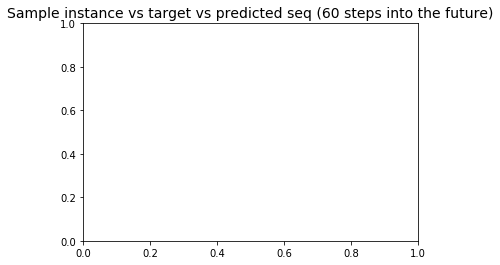

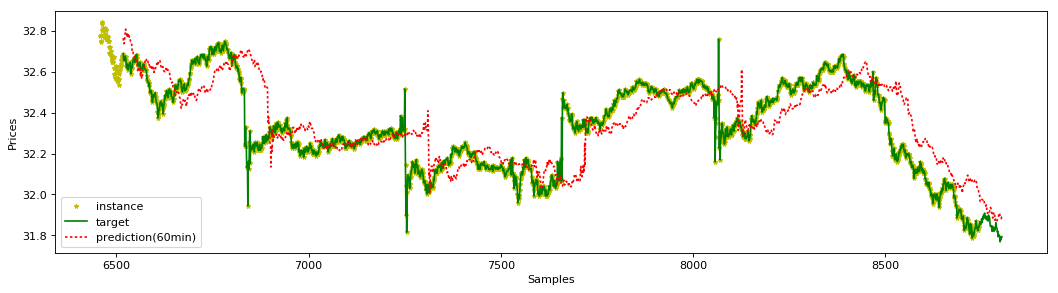

In [734]:
import matplotlib.pyplot as plt

# Plot instance vs target vs predicted values  (for 60min into future)
# Print for an approximate time window of last 5 days of the month
lag=60
start=len(prices_normal)-n_steps   # last 5 days of the month
x_label=np.arange(0, len(prices_test['Close']), 1).tolist()

plt.title("Sample instance vs target vs predicted seq (60 steps into the future)", fontsize=14)
plt.figure(figsize=(16,4), dpi=80)
plt.plot(x_label[start-lag:-2*lag], prices_test['Close'][start-lag:-2*lag], "y*", markersize=4, label="instance")
plt.plot(x_label[start:-lag], prices_test['Close'][start:-lag], "g-", markersize=1, label="target")
plt.plot(x_label[start:-lag], prices_test['ClosePred60'][start:-lag], "r:", markersize=2, label="prediction(60min)")

plt.legend(loc="lower left")
plt.xlabel("Samples")
plt.ylabel("Prices")
plt.show()

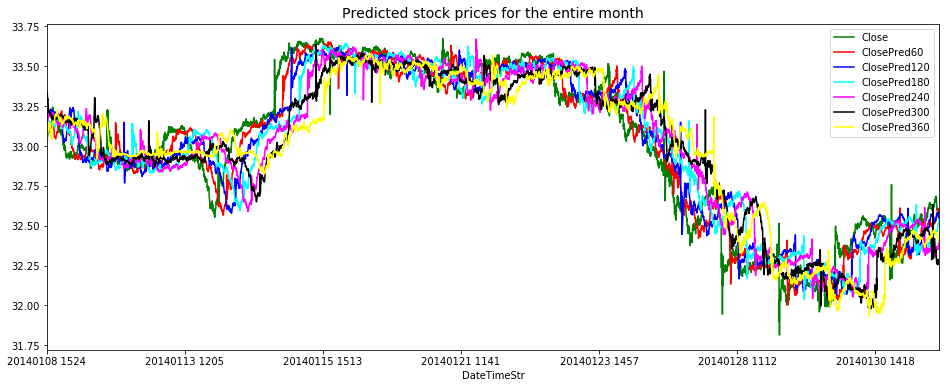

In [739]:
plt.figure(figsize=(16,6))
plt.subplot(111)
lag=450                            # skip last batch of values across to have same time frame for all predictions.
prices_test.iloc[n_steps:-lag].plot(x='DateTimeStr', y='Close', color='green', ax=plt.gca())
prices_test.iloc[n_steps:-lag].plot(x='DateTimeStr', y='ClosePred60', color='red', ax=plt.gca())
prices_test.iloc[n_steps:-lag].plot(x='DateTimeStr', y='ClosePred120', color='blue', ax=plt.gca())
prices_test.iloc[n_steps:-lag].plot(x='DateTimeStr', y='ClosePred180', color='cyan', ax=plt.gca())
prices_test.iloc[n_steps:-lag].plot(x='DateTimeStr', y='ClosePred240', color='magenta', ax=plt.gca())
prices_test.iloc[n_steps:-lag].plot(x='DateTimeStr', y='ClosePred300', color='black', ax=plt.gca())
prices_test.iloc[n_steps:-lag].plot(x='DateTimeStr', y='ClosePred360', color='yellow', ax=plt.gca())
plt.title("Predicted stock prices for the entire month", fontsize=14)
plt.show()

##OBSERVATION: 
1. We see that the predictions here are much worse as the prediction window grows. We do see that the predictions have picked-up for short term (60min window) and overall, picked up the long-term patterns. 
2. We are using #steps equivalent to 5 days worth of trading data. Noticing that there is no improvement over #steps using 2 days worth of trading data (see XLK-RNN-2days.ipynb).